In [1]:
from TicTacToe import TicTacToe
from Players import RandomPlayer, RandomWinner, RandomWinnerBlocker, Player
from Learners import ReinforcementTicTacToeLearner

from functools import lru_cache
import matplotlib.pyplot as plt

import numpy as np
import random

### Example of a game between two random players

In [2]:
p1 = RandomPlayer('O')
p2 = RandomPlayer('X')

game = TicTacToe()
p1_next=True

while True:
    if p1_next:
        p1.move(game)
    else:
        p2.move(game)
        
    p1_next = not p1_next
    game.print_board()
    
    if game.game_over():
        game.print_board()

        print('game over')
        break
    if game.winner():
        game.print_board()

        print(f"Winner: {game.winner()}")
        break
    



|   |
|O  |
|   |


|   |
|O  |
|  X|


| O |
|O  |
|  X|


| O |
|OX |
|  X|


|OO |
|OX |
|  X|


|OO |
|OX |
|X X|


|OO |
|OX |
|XOX|


|OOX|
|OX |
|XOX|


|OOX|
|OX |
|XOX|


Winner: X


In [2]:
def plot_wld(wld):

    def subplot(wld_arr, ax):

        ws = np.cumsum([1 if x[1] == 'w' else 0 for x in wld_arr])
        ds = np.cumsum([1 if x[1] == 'l' else 0 for x in wld_arr])
        ls = np.cumsum([1 if x[1] == 'd' else 0 for x in wld_arr])

        ax.plot(ws, label='w')
        ax.plot(ds, label='d')
        ax.plot(ls, label='l')

        return ax

    first = list(filter(lambda x: x[0] is True, wld))
    second = list(filter(lambda x: x[0] is False, wld))

    fig, axs = plt.subplots(1, 2, sharey=True)

    axs[0] = subplot(first, axs[0])
    axs[1] = subplot(second, axs[1])

    axs[0].set_title('Played First')
    axs[1].set_title('Played Second')

    axs[0].set_xlabel('Games')
    plt.legend()

    return fig, axs


### Train against 3 different players and plot WLD 

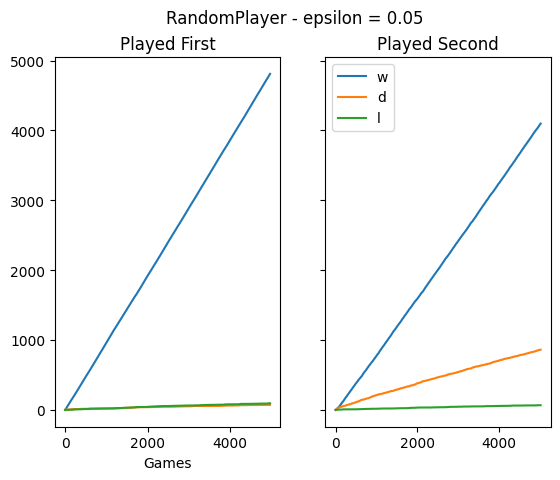

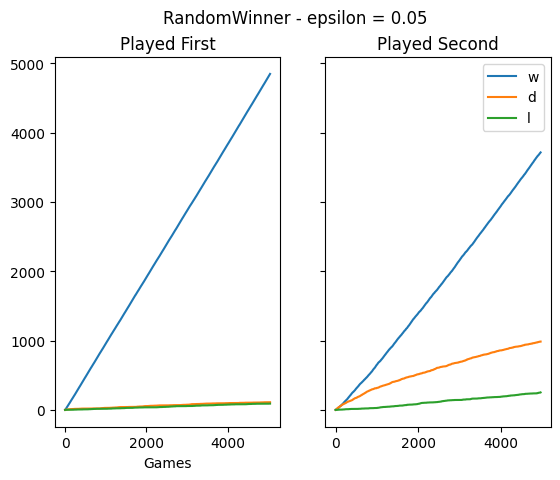

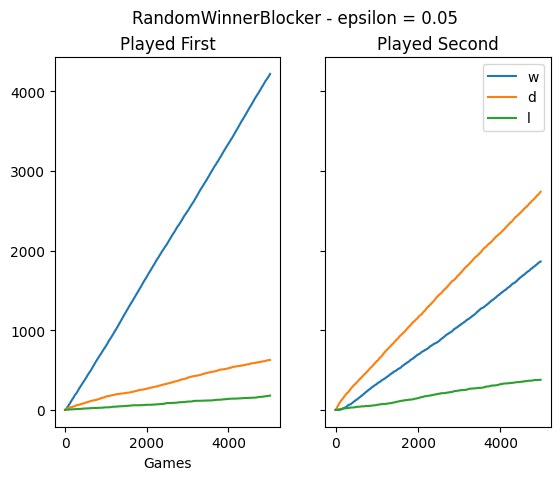

In [3]:
for opponent in [RandomPlayer, RandomWinner, RandomWinnerBlocker]:

    rlearner = ReinforcementTicTacToeLearner(10000, 0.05, opponent(player='O'), player='X')
    state, wld = rlearner.learn()

    fig, axs = plot_wld(wld)
    fig.suptitle(f"{type(rlearner.oppoent).__name__} - epsilon = {rlearner.epsilon}")
    plt.show()
    